# 1. Data & Preprocessing

In [1]:
import os

import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import Dataset

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import argparse

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import DBSCAN

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Random seed (for reproducibility)
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## Datasets, dataloaders and transformations

In [3]:
BATCH_SIZE = 128

In [4]:
class data_set(Dataset):
  """for Combined dataset."""
  def __init__(self, dataset, targets):
    self.dataset = dataset
    self.targets = targets
      
  def __getitem__(self, idx):
    image = self.dataset[idx][0]
    target = self.targets[idx]
    return (image, target)

  def __len__(self):
    return len(self.dataset)

MNIST - for training

In [5]:
mnist_transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(
                                  (0.1307,),
                                  (0.3081,)), # mnist mean & std
                              transforms.Resize(28)])

mnist_train_set = torchvision.datasets.MNIST(root='./data',
                                                 train=True,
                                                 download=True,
                                                 transform=mnist_transform)

mnist_test_set = torchvision.datasets.MNIST(root='./data',
                                            train=False,
                                            download=True,
                                            transform=mnist_transform)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 num_workers=2)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test_set,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                num_workers=2)

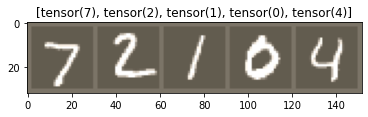

In [6]:
# Printing 5 MNIST data examples
inputs, classes = next(iter(mnist_test_loader))
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[x for x in classes[:5]])

CIFAR10 as OOD dataset - for evaluation

In [7]:
CIFAR10_SUBSET_SIZE = 500

cifar10_transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(
                                  (0.4914, 0.4822, 0.4465),
                                  (0.247, 0.243, 0.261)), # cifar10 mean & std
                              transforms.Resize(28),
                              transforms.Grayscale(num_output_channels=1)])

cifar10_test_set = torchvision.datasets.CIFAR10(root='./data',
                                              train=False,
                                              download=True,
                                              transform=cifar10_transform)

cifar10_test_subset_data = torch.utils.data.Subset(cifar10_test_set,
                                                   np.random.choice(range(len(cifar10_test_set)),
                                                                    size=CIFAR10_SUBSET_SIZE))
sub_cifar10_targets = [10 for i in range(CIFAR10_SUBSET_SIZE)]
cifar10_test_subset = data_set(cifar10_test_subset_data, sub_cifar10_targets)

cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_subset,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                num_workers=2)

Files already downloaded and verified


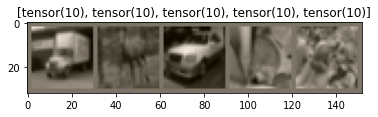

In [8]:
# Printing 5 CIFAR10 data examples
inputs, classes = next(iter(cifar10_test_loader))
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[x for x in classes[:5]])

In [9]:
combined_test_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset([mnist_test_set, cifar10_test_subset]),
        batch_size=BATCH_SIZE, shuffle=True)

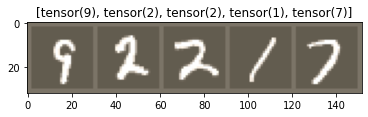

In [10]:
# Printing 5 COMBINED data examples
inputs, classes = next(iter(combined_test_loader))
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[x for x in classes[:5]])


# 2. Models

In [11]:
def out_size(W, F, S, P):
  return ((W-F+2*P) // S) + 1

Baseline model class

In [12]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
    self.conv3 = nn.Conv2d(32,64, kernel_size=5)
    self.fc1 = nn.Linear(3*3*64, 256)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.dropout(x, p=0.5, training=self.training)

    x = F.relu(F.avg_pool2d(self.conv2(x), 2))
    x = F.dropout(x, p=0.5, training=self.training)

    x = F.relu(F.avg_pool2d(self.conv3(x),2))
    x = F.dropout(x, p=0.5, training=self.training)

    x = x.view(-1, 3*3*64)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)

    x = self.fc2(x)
    return x

OSR model class

In [13]:
class OSR(nn.Module):
  def __init__(self, state_dict = None, dropout = 0.3, **kwargs):
    super(OSR, self).__init__()

    self.num_classes = 10
    self.cnn = CNN()
    if state_dict is not None:
      self.cnn.load_state_dict(state_dict)
    
    self.classify = nn.Linear(self.num_classes, self.num_classes)
    self.anchors = nn.Parameter(torch.diag(torch.Tensor([10 for i in range(10)])).double(), requires_grad = False)

  def forward(self, x):
    batch_size = len(x)
    x = self.cnn(x)
    outLinear = x.view(batch_size, -1)
    outLinear = self.classify(x)
    outDistance = self.distance_classifier(outLinear)

    return outDistance

  def distance_classifier(self, outLinear):
    ''' Calculates euclidean distance from outLinear to each class anchor
      Returns n x m array of distance from input of batch_size n to anchors of size m
    '''
    n = outLinear.size(0)
    m = self.num_classes
    d = self.num_classes

    outLinear = outLinear.unsqueeze(1).expand(n, m, d).double()
    anchors = self.anchors.unsqueeze(0).expand(n, m, d)
    dists = torch.norm(outLinear-anchors, 2, 2)

    return dists

# 3. Training


Training procedure for baseline model

In [14]:
def train(model, criterion, train_loader):
  optimizer = torch.optim.Adam(model.parameters())#,lr=0.001, betas=(0.9,0.999))
  EPOCHS = 5 # return to 5 at the end
  model.train()
  
  for epoch in range(EPOCHS):
    print('--------------- Epoch : {} -------------'.format(epoch + 1))
    correct = 0
    loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()

      outputs = model(inputs)
      
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      if batch_idx % 100 == 0:
        print('[{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              batch_idx*len(inputs),
              len(train_loader.dataset),
              100.*batch_idx / len(train_loader),
              loss.data))

In [15]:
cnn = CNN()
if torch.cuda.is_available():
    cnn.cuda()

criterion = nn.CrossEntropyLoss()
train(cnn, criterion, mnist_train_loader)

--------------- Epoch : 1 -------------
[0/60000 (0%)]	Loss: 2.308709
[12800/60000 (21%)]	Loss: 0.370760
[25600/60000 (43%)]	Loss: 0.307374
[38400/60000 (64%)]	Loss: 0.165370
[51200/60000 (85%)]	Loss: 0.176129
--------------- Epoch : 2 -------------
[0/60000 (0%)]	Loss: 0.129568
[12800/60000 (21%)]	Loss: 0.108404
[25600/60000 (43%)]	Loss: 0.110516
[38400/60000 (64%)]	Loss: 0.258516
[51200/60000 (85%)]	Loss: 0.058577
--------------- Epoch : 3 -------------
[0/60000 (0%)]	Loss: 0.099398
[12800/60000 (21%)]	Loss: 0.095390
[25600/60000 (43%)]	Loss: 0.060696
[38400/60000 (64%)]	Loss: 0.073690
[51200/60000 (85%)]	Loss: 0.144677
--------------- Epoch : 4 -------------
[0/60000 (0%)]	Loss: 0.035941
[12800/60000 (21%)]	Loss: 0.049624
[25600/60000 (43%)]	Loss: 0.040924
[38400/60000 (64%)]	Loss: 0.154610
[51200/60000 (85%)]	Loss: 0.028722
--------------- Epoch : 5 -------------
[0/60000 (0%)]	Loss: 0.042716
[12800/60000 (21%)]	Loss: 0.093498
[25600/60000 (43%)]	Loss: 0.087175
[38400/60000 (64%)]	

Training procedure for OSR model

\begin{align}
  \mathbf{Loss}_T(\pmb{x},y) =
  \log \left(1 + \sum_{j \ne y}^N \exp\left(d_y - d_j\right)\right)
  \end{align}

\begin{align}
  \mathbf{Loss}_A(\pmb{x},y) = d_y
  \end{align}

\begin{align}
  \mathbf{Loss}_{CAC}(\pmb{x},y) =
  \mathbf{Loss}_T(\pmb{x},y) + \lambda \cdot \mathbf{Loss}_A(\pmb{x},y)
  \end{align}

In [16]:
def Loss_CAC(distances, targets, lmbda=0.1):
	'''Returns CAC loss'''
	true_distances = torch.gather(distances, 1, targets.view(-1, 1)).view(-1)
	non_true_distances = torch.Tensor([[i for i in range(10) if targets[x] != i] for x in range(len(distances))]).long().to(device)
	other_distances = torch.gather(distances, 1, non_true_distances)
	
	loss_A = torch.mean(true_distances)

	loss_T = torch.exp(true_distances.unsqueeze(1) - other_distances)
	loss_T = torch.mean(torch.log(1+torch.sum(loss_T, dim = 1)))

	loss_CAC = loss_T + lmbda * loss_A

	return loss_CAC

In [17]:
osr = OSR(cnn.state_dict())

if torch.cuda.is_available():
  osr.cuda()

criterion = Loss_CAC
train(osr, criterion, mnist_train_loader)

--------------- Epoch : 1 -------------
[0/60000 (0%)]	Loss: 7.179957
[12800/60000 (21%)]	Loss: 0.905997
[25600/60000 (43%)]	Loss: 0.619928
[38400/60000 (64%)]	Loss: 0.522615
[51200/60000 (85%)]	Loss: 0.479175
--------------- Epoch : 2 -------------
[0/60000 (0%)]	Loss: 0.471547
[12800/60000 (21%)]	Loss: 0.519570
[25600/60000 (43%)]	Loss: 0.426378
[38400/60000 (64%)]	Loss: 0.472053
[51200/60000 (85%)]	Loss: 0.488158
--------------- Epoch : 3 -------------
[0/60000 (0%)]	Loss: 0.365901
[12800/60000 (21%)]	Loss: 0.404919
[25600/60000 (43%)]	Loss: 0.504908
[38400/60000 (64%)]	Loss: 0.333389
[51200/60000 (85%)]	Loss: 0.378154
--------------- Epoch : 4 -------------
[0/60000 (0%)]	Loss: 0.308553
[12800/60000 (21%)]	Loss: 0.412187
[25600/60000 (43%)]	Loss: 0.347746
[38400/60000 (64%)]	Loss: 0.343975
[51200/60000 (85%)]	Loss: 0.315479
--------------- Epoch : 5 -------------
[0/60000 (0%)]	Loss: 0.398127
[12800/60000 (21%)]	Loss: 0.336730
[25600/60000 (43%)]	Loss: 0.384787
[38400/60000 (64%)]	

# 4. Evaluation

In [18]:
def get_cnn_prediction(outputs):
  return torch.max(outputs, 1)[1]

In [19]:
def get_osr_prediction(outputs, threshold=0.5):
  softmin = torch.nn.Softmin(dim=1)
  invScores = 1 - softmin(outputs)
  scores = torch.Tensor(outputs * invScores).detach().cpu()
  pred_value, prediction = torch.min(scores, axis=1)
  prediction[pred_value > threshold] = 10
  return torch.Tensor(prediction).to(device)

In [20]:
dictionary = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:1}

def evaluate(model, labels, get_prediction, test_loader, binary=False):
  y_true = []
  y_pred = []
  correct = 0
  with torch.no_grad():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      predicted = get_prediction(outputs)

      correct += (predicted == targets).sum()

      y_true += list(targets.detach().cpu())
      y_pred += list(predicted.detach().cpu())

    if binary:
      y_true = [dictionary[int(y)] for y in y_true]
      y_pred = [dictionary[int(y)] for y in y_pred]

    print("Evaluation accuracy on the testing set: {:.3f}% ".format(
        float(correct*100) / (len(test_loader)*BATCH_SIZE)))
    
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_title("Confusion Matrix")
    disp.plot(cmap='Reds', ax=ax)
    plt.show()

    return cm

Baseline results

Evaluation accuracy on the testing set: 96.816% 


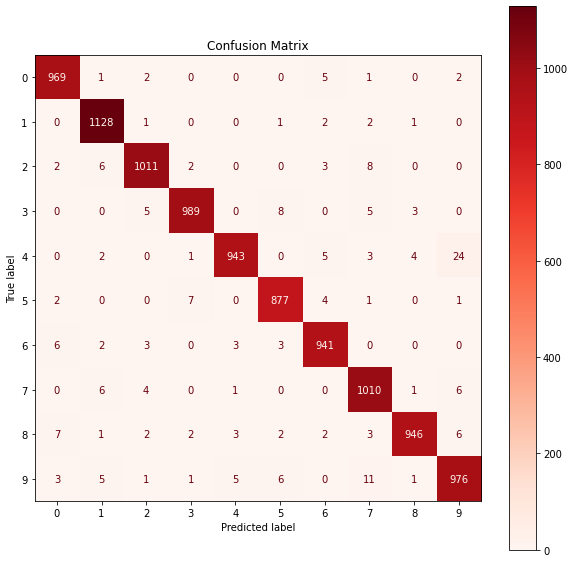

In [21]:
baseline_c_matrix = evaluate(cnn, range(10), get_cnn_prediction, mnist_test_loader)

OSR rational

:TODO - create a comparison between the cross-entropy loss and the CAC one. see the difference

OOD results

Evaluation accuracy on the testing set: 93.091% 


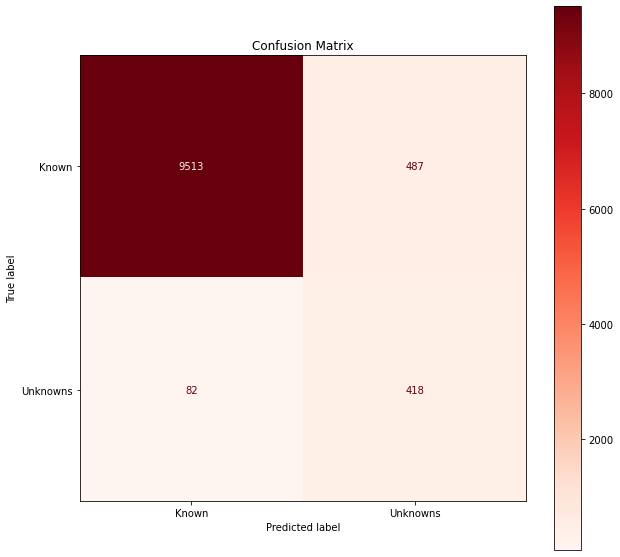

In [22]:
ood_c_matrix = evaluate(osr, ['Known', 'Unknowns'], get_osr_prediction, combined_test_loader, True)

OSR results

Evaluation accuracy on the testing set: 93.232% 


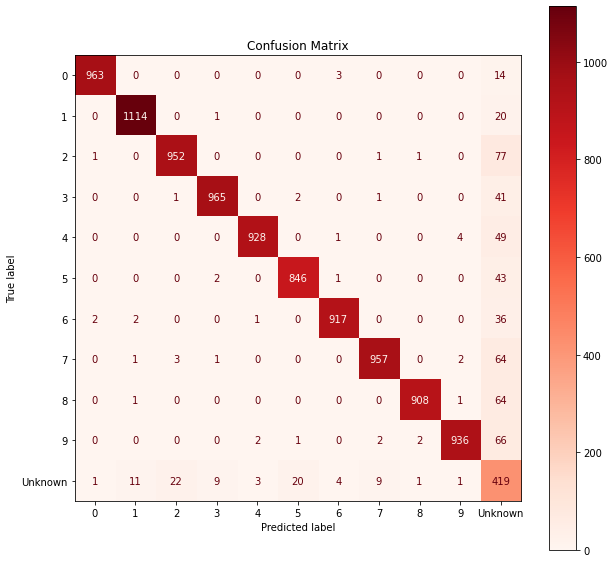

In [23]:
osr_c_matrix = evaluate(osr, list(range(10)) + ['Unknown'], get_osr_prediction, combined_test_loader)

In [24]:
def visualize_model(model, get_prediction, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(combined_test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            predicted = get_prediction(outputs)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {predicted[j]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

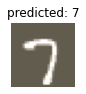

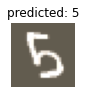

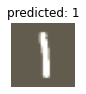

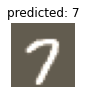

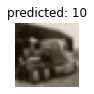

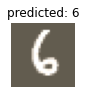

In [25]:
visualize_model(osr, get_osr_prediction, 6)

## Reference
[1] Miller, Dimity and Suenderhauf, Niko and Milford, Michael and Dayoub, Feras. Class Anchor Clustering: A Loss for Distance-Based Open Set Recognition. In *Proceedings of the IEEE/CVF Winter Conference on Applications of Computer Vision*, pages 3,570-3,578